In [1]:
%run init_model.py 'algo_ml_long_short_predict'

algo_ml_long_short_predict


# Step 1) Data Preparation

In [2]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-s3bucket-hjkat4exa4o6'

In [3]:
import sys
!{sys.executable} -m pip install PyAthena

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

In [5]:
import pandas as pd
from pyathena import connect
conn = connect(s3_staging_dir='s3://'+s3bucket+'/results/',
               region_name=region)

df = pd.read_sql("SELECT dt,open,high,low,close,vol FROM algo_data.hist_data_daily;", conn)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

,open,high,low,close,vol
dt,,,,,
2000-01-03,93.13,93.75,91.69,92.19,2321200.0
2000-01-04,91.13,91.56,88.75,88.81,3911100.0
2000-01-05,88.81,90.81,88.44,90.19,4114800.0
2000-01-06,90.31,93.94,90.13,92.56,2678200.0
2000-01-07,94.13,96.94,93.63,96.50,4931900.0


In [6]:
trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local/'+algo_name+'/input/data/training/data.csv')
dfTest.head()

,open,high,low,close,vol
dt,,,,,
2008-04-14,65.92,66.42,65.74,65.74,10326800.0
2008-04-15,65.63,66.02,64.99,65.65,17362000.0
2008-04-16,65.79,65.91,65.13,65.70,12617900.0
2008-04-17,65.64,66.00,65.55,65.76,8841500.0
2008-04-18,66.50,66.80,65.94,66.51,10741100.0


<IPython.core.display.Javascript object>


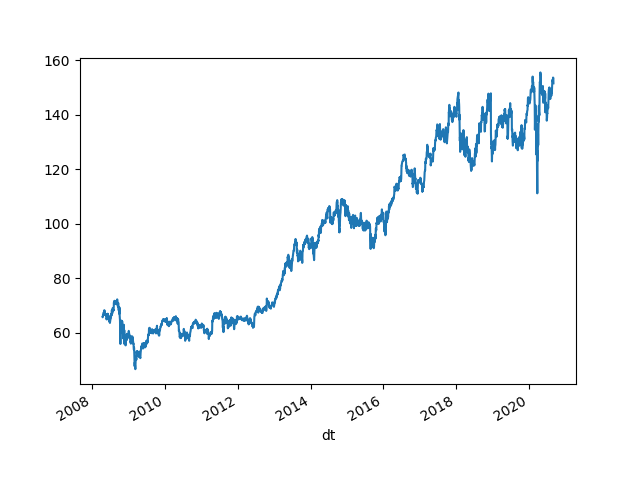

In [7]:
%matplotlib notebook
dfTest["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, you can adjust the parameters for the strategy.

* `user` = Name for Leaderboard (optional)
* `long_threshold` = Threshold for Long Trade (0 to 1)
* `short_threshold` = Threshold for Short Trade (0 to 1)
* `profit_target_pct` = Profit Target Percentage 
* `stop_target_pct` = Stop Target Percentage
* `size` = The number of shares for a transaction

`Tip`: A good starting point for improving the strategy is modify the profit / stop target and the risk/reward ratio. Another option is to reduce the number of signals by increasing the threshold.

In [8]:
%%writefile local/{algo_name}/input/config/hyperparameters.json
{ "user" : "user",
  "long_threshold" : "0.5",
  "short_threshold" : "0.5",
  "profit_target_pct" : "2.00",
  "stop_target_pct" : "1.50",
  "size" : "100"
}

Writing local/algo_ml_long_short_predict/input/config/hyperparameters.json


In [9]:
%run update_config.py $algo_name

config={"user": "user", "long_threshold": "0.5", "short_threshold": "0.5", "profit_target_pct": "2.00", "stop_target_pct": "1.50", "size": "100", "algo_name": "algo_ml_long_short_predict", "account": "707125770334", "region": "us-east-2"}


# Step 3) Modify Strategy Code

In the following cell, you can modify the strategy code. For the first backtests, you can leave it as is.

`Tip`: A good starting point for improving the strategy is to combine the signal from the model with traditional trend indicators (e.g. moving average). This will likely improve the performance. To improve the strategy further, you could increase the accuracy of the machine learning model by including more indicators (e.g. ATR) or modify the input and forecast window. This requires to re-train the machine learning model as this needs to match your strategy. For timeseries forecasting, you could compare the performance with more advanced ML networks (e.g. CNN, LTSM, RNN) and pick the model with the best predictions.

You can also checkout other AWS-provided options for timeseries forecasting and formulate a strategy that uses price predictions and integrate them in your strategy:
* https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html 
* https://aws.amazon.com/forecast/

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [10]:
%%writefile model/{algo_name}.py
import backtrader as bt
from algo_base import *
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model

class MyStrategy(StrategyTemplate):

    def __init__(self):
        super(MyStrategy, self).__init__()
        self.config["long_threshold"]=float(self.config["long_threshold"])
        self.config["short_threshold"]=float(self.config["short_threshold"])
        self.config["size"]=int(self.config["size"])
        self.config["profit_target_pct"]=float(self.config["profit_target_pct"])
        self.config["stop_target_pct"]=float(self.config["stop_target_pct"])

        self.order=None
        self.orderPlaced=False
                                
        self.model = load_model('model_long_short_predict.h5')
        
        # input / indicators
        self.repeatCount=15
        self.repeatStep=1
        
        self.profitTarget=self.config["profit_target_pct"]/100.0
        self.stopTarget=self.config["stop_target_pct"]/100.0
        self.size=self.config["size"]
         
        self.sma=[]
        self.roc=[]
        
        self.hData=["dt"]
        self.hData.append("close") 
        for a in range(0,self.repeatCount):
            tp=(a+1)*self.repeatStep+1
            self.hData.append("sma"+str(tp))
            self.sma.append(bt.talib.SMA(self.data, timeperiod=tp, plot=False))
        for a in range(0,self.repeatCount):
            tp=(a+1)*self.repeatStep+1
            self.hData.append("roc"+str(tp))
            self.roc.append(bt.talib.ROC(self.data, timeperiod=tp, plot=False))

    def init_broker(broker):
        broker.setcash(100000.0)
        broker.setcommission(commission=0.0) 
        
    def add_data(cerebro):
        data = btfeeds.GenericCSVData(
            dataname=MyStrategy.TRAIN_FILE,
            dtformat=('%Y-%m-%d'),
            timeframe=bt.TimeFrame.Days,
            datetime=0,
            time=-1,
            high=2,
            low=3,
            open=1,
            close=4,
            volume=5,
            openinterest=-1
        )
        cerebro.adddata(data)

    def next(self):
        super(MyStrategy, self).next()
        
        dt=self.datas[0].datetime.datetime(0)
        cl=self.dataclose[0]
        inputRec=[]                

        #open
        inputRec0=[]
        inputRec0.append(cl)

        #sma
        for a in range(0,self.repeatCount):
            if math.isnan(self.sma[a][0]):
                inputRec0.append(cl)
            else:
                inputRec0.append(self.sma[a][0])

        m1=min(inputRec0)
        m2=max(inputRec0)
        for a in inputRec0:
            if m2-m1==0:
                inputRec.append(0)
            else:
                inputRec.append((a-m1)/(m2-m1))

        #roc
        for a in range(0,self.repeatCount):
            if math.isnan(self.roc[a][0]):
                inputRec.append(0)
            else:
                inputRec.append(self.roc[a][0])

        mX=[]
        mX.append(np.array(inputRec))
        dataX=np.array(mX)
        #print("dataX=%s" % dataX)

        # *** ML prediction ***
        mY=self.model.predict(dataX)
        #print("mY=%s" % mY)
        tLong=mY[0][0]
        tShort=mY[0][1]
        #print("[%s]:long=%s,short=%s" % (dt,tLong,tShort))
        if not self.position:
            fLong=(tLong>self.config["long_threshold"]) 
            fShort=(tShort>self.config["short_threshold"])
            if fLong:
                self.order=self.buy(size=self.size)
                self.limitPrice=cl+self.profitTarget*cl
                self.stopPrice=cl-self.stopTarget*cl
            elif fShort:
                self.order=self.sell(size=self.size)                    
                self.limitPrice=cl-self.profitTarget*cl
                self.stopPrice=cl+self.stopTarget*cl

        if self.position:
            if self.position.size>0:
                if cl>=self.limitPrice or cl<=self.stopPrice:
                    self.order=self.sell(size=self.size)
            elif self.position.size<0:
                if cl<=self.limitPrice or cl>=self.stopPrice:
                    self.order=self.buy(size=self.size)

Writing model/algo_ml_long_short_predict.py


# Step 4) Backtest Locally

**Please note that the initial docker build may take a few minutes. Subsequent runs are fast.**

In [11]:
#Build Local Algo Image
!docker build -t $algo_name .
!docker run -v $(pwd)/local/$algo_name:/opt/ml --rm $algo_name train

Sending build context to Docker daemon  4.517MB
Step 1/22 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/22 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> fc51ded0052f
Step 3/22 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> a298494f8656
Step 4/22 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py
 ---> Using cache
 ---> 55d001ee1cf3
Step 5/22 : RUN pip install numpy
 ---> Using cache
 ---> 6a6094db0d7d
Step 6/22 : RUN pip install scipy
 ---> Using cache
 ---> 001df69be031
Step 7/22 : RUN pip install scikit-learn
 ---> Using cache
 ---> 0b6d91b04180
Step 8/22 : RUN pip i

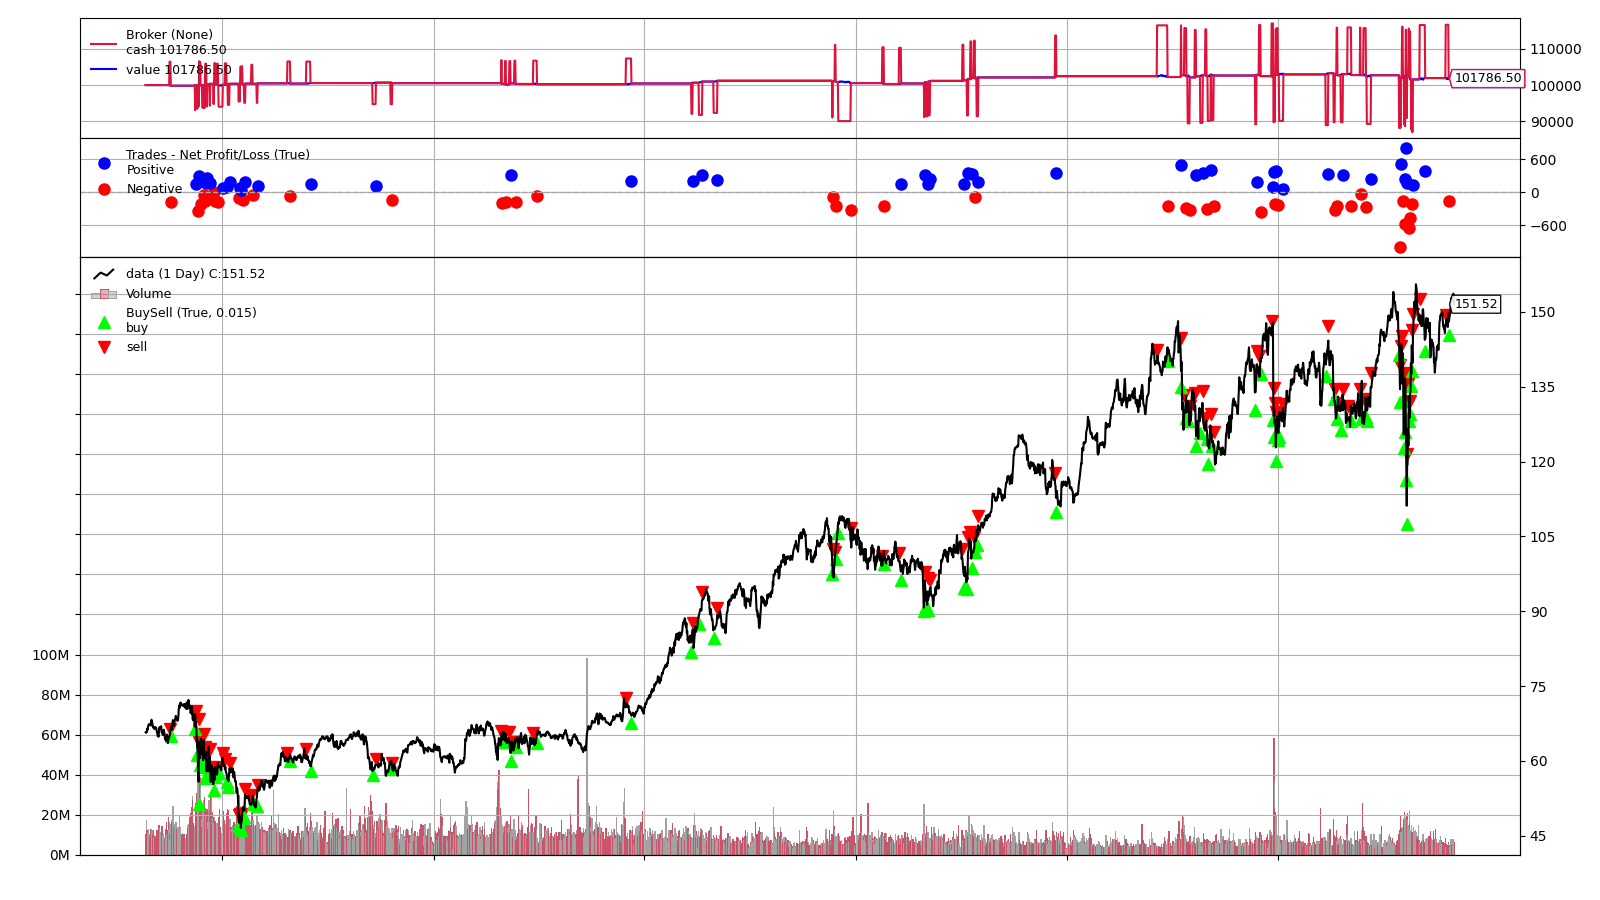

In [12]:
from IPython.display import Image
Image(filename='local/'+algo_name+'/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready, move on to the next step.

# Step 5) Backtest on SageMaker and submit performance

In [13]:
#Deploy Algo Image to ECS
!./build_and_push.sh $algo_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  5.086MB
Step 1/22 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/22 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> fc51ded0052f
Step 3/22 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> a298494f8656
Step 4/22 : RUN wget https://bootstrap.pyp

In [14]:
#Run Remote Forwardtest via SageMaker
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+algo_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+algo_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
#config['sim_data']='True'
print(config)

prefix=algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

s3://sagemaker-us-east-2-707125770334/data
{'user': 'user', 'long_threshold': '0.5', 'short_threshold': '0.5', 'profit_target_pct': '2.00', 'stop_target_pct': '1.50', 'size': '100', 'algo_name': 'algo_ml_long_short_predict', 'account': '707125770334', 'region': 'us-east-2'}
2021-02-16 09:22:11 Starting - Starting the training job...
2021-02-16 09:22:34 Starting - Launching requested ML instancesProfilerReport-1613467331: InProgress
......
2021-02-16 09:23:35 Starting - Preparing the instances for training...
2021-02-16 09:24:09 Downloading - Downloading input data...
2021-02-16 09:24:36 Training - Downloading the training image............
2021-02-16 09:26:37 Training - Training image download completed. Training in progress.import:algo_ml_long_short_predict
<class 'algo_ml_long_short_predict.MyStrategy'>
[INIT]:config:/opt/ml/input/config/hyperparameters.json={'algo_name': 'algo_ml_long_short_predict', 'short_threshold': '0.5', 'long_threshold': '0.5', 'size': '100', 'profit_target_pc

In [15]:
#Get Algo Metrics
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,algo:pnl,1786.50
1,0.0,algo:sharpe_ratio,-1.48


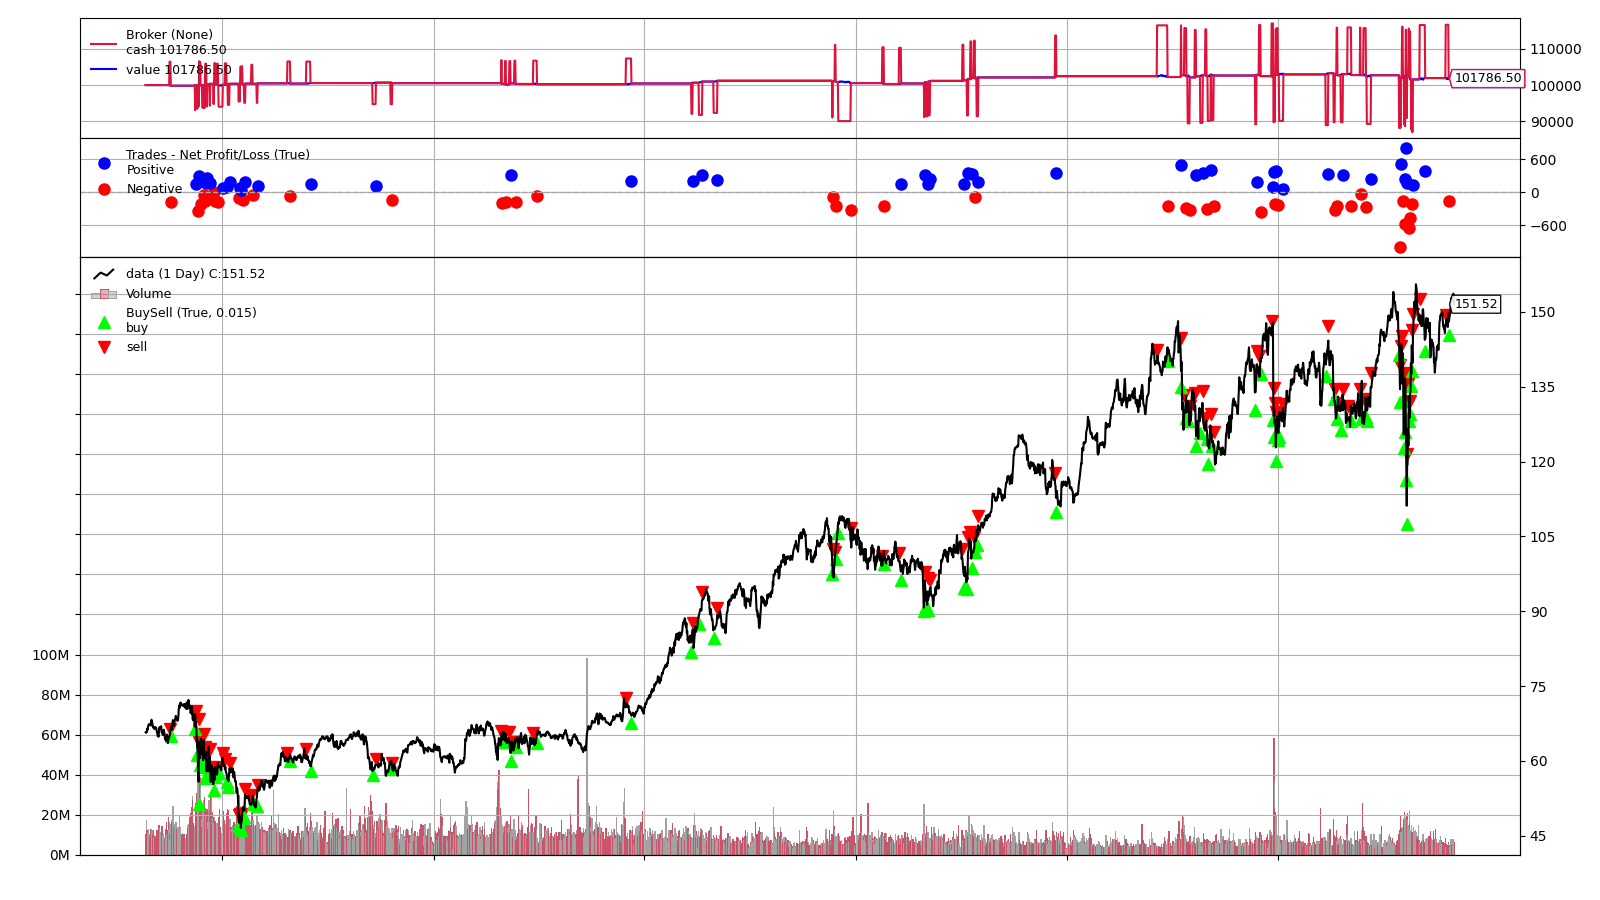

In [16]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 

### Congratulations! You've completed this strategy.